In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import json

# Preparing dataset

In [ ]:
!gdown "19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t"
!gdown "1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t"

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t 

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t 



In [ ]:
!unzip /content/Dataset.zip -d Dataset
!unzip /content/Patterns.zip -d Patterns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/Uni/Term9/CV/project/Dataset.zip -d Dataset
!unzip /content/drive/MyDrive/Uni/Term9/CV/project/Patterns.zip -d Patterns

# Viewing images

In [ ]:
img_name = "/content/Dataset/1644360063.82364.jpg"
json_name = img_name[:-3] + "json"

{'version': '4.6.0', 'flags': {}, 'shapes': [{'label': 'tarak', 'points': [[897.7653198242188, 1586.5467529296875], [886.7998657226562, 1587.4310302734375], [886.5553588867188, 1551.6741943359375], [886.9356689453125, 1356.078857421875], [898.9793701171875, 1252.533203125], [870.9920654296875, 1133.7435302734375], [851.4662475585938, 1005.3465576171875], [845.7804565429688, 871.1670532226562], [844.9558715820312, 752.86328125], [838.8675537109375, 588.9474487304688], [851.4467163085938, 588.95458984375], [859.8489379882812, 651.9498901367188], [860.90185546875, 764.6051635742188], [858.870361328125, 862.271728515625], [860.3362426757812, 906.1453247070312], [867.2560424804688, 1039.2200927734375], [886.4782104492188, 1126.6287841796875], [909.3640747070312, 1236.4354248046875], [953.4122924804688, 1239.0584716796875], [954.0599975585938, 1247.99072265625], [913.2735595703125, 1248.9281005859375], [900.2054443359375, 1357.7305908203125], [898.634033203125, 1526.098388671875]], 'group_id

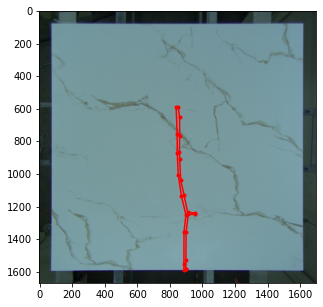

In [ ]:
img = cv2.imread(img_name)

f = open(json_name, encoding="utf8")
data = json.load(f)
print(data)
f.close()

plt.figure(figsize=(5, 5))
plt.imshow(img[..., ::-1])

for shape in data["shapes"]:
  points = np.array(shape['points'])
  ind = list(np.arange(points.shape[0])) + [0]
  plt.plot(points[ind, 0], points[ind, 1], 'r.-')
  # plt.plot(points[-1:-3:-1, 0], points[-1:-3:-1, 1], 'r')

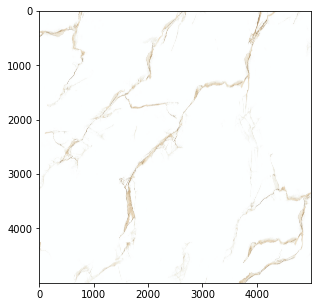

In [ ]:
pattern = cv2.imread('/content/Patterns/' + data['pattern'])

plt.figure(figsize=(5, 5))
plt.imshow(pattern[..., ::-1])

In [62]:
#create blank mask with image sizes
def create_binary_masks(im, shape_dicts):
    
    blank = np.zeros(shape=(im.shape[0], im.shape[1]), dtype=np.float32)
    for shape in shape_dicts:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(blank, [points], 255)
    return blank

#get annotated points
def get_poly(ann_path):
    
    with open(ann_path) as handle:
        data = json.load(handle)
    shape_dicts = data['shapes']
    
    return shape_dicts

def get_file_name(im_path):
    if (".png" in im_path):
        filename = im_path.split('.png')[-2].split('/')[-1] + '.png'
    elif (".jpg" in im_path):
        filename = im_path.split('.jpg')[-2].split('/')[-1] + '.jpg'
    elif (".bmp" in im_path):
        filename = im_path.split('.bmp')[-2].split('/')[-1] + '.bmp'
    
    return filename


In [64]:
import os

try: 
    os.mkdir("Labels")
    print("directory created")
except OSError as error: 
    print("already created")

directory created


In [65]:
#iterate every image and its json file to create binary mask
labels_path_list = []
for im_fn, ann_fn in zip(images_path_list, ann_list):
    
    im = cv2.imread(im_fn, 0)
    shape_dicts = get_poly(ann_fn)
    im_binary = create_binary_masks(im, shape_dicts)
    
    #extract the name of image file
    filename = get_file_name(im_fn)
    cv2.imwrite(label_dir + filename, im_binary)
    labels_path_list.append(label_dir + filename)

# Finding contours
We should use key points to match the pictures to patterns 

In [ ]:
def remove_pattern_noise(img): 
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ret,otsu_thresh = cv2.threshold(gray_img,127,200,cv2.THRESH_BINARY)

  kernel = np.ones((39, 39), np.uint8)

  closing = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE,
                            kernel, iterations=1)

  return cv2.Canny(np.uint8(closing), 80, 120)

output = remove_pattern_noise(img)

In [ ]:
def find_vertices(im):
    contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    Minn, area = 0, 0
    for s in contours:
        area_hold = cv2.contourArea(s)
        if area_hold > area :
            Minn = s
            area = area_hold

    return cv2.approxPolyDP(Minn, 0.01*cv2.arcLength(Minn,True),True)

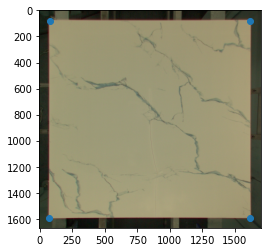

In [ ]:
vertices = find_vertices(output)
plt.imshow(img)
plt.scatter([x[0][0] for x in vertices], [x[0][1] for x in vertices])

In [ ]:
#save all image files and json files separately to list
import glob

input_dir = "/content/Dataset/"
label_dir = "/content/Labels/"

images_path_list = sorted(glob.glob(input_dir + "*.png") + glob.glob(input_dir + "*.jpg") + glob.glob(input_dir + "*.bmp"))
ann_list = sorted(glob.glob(input_dir + "*.json"))

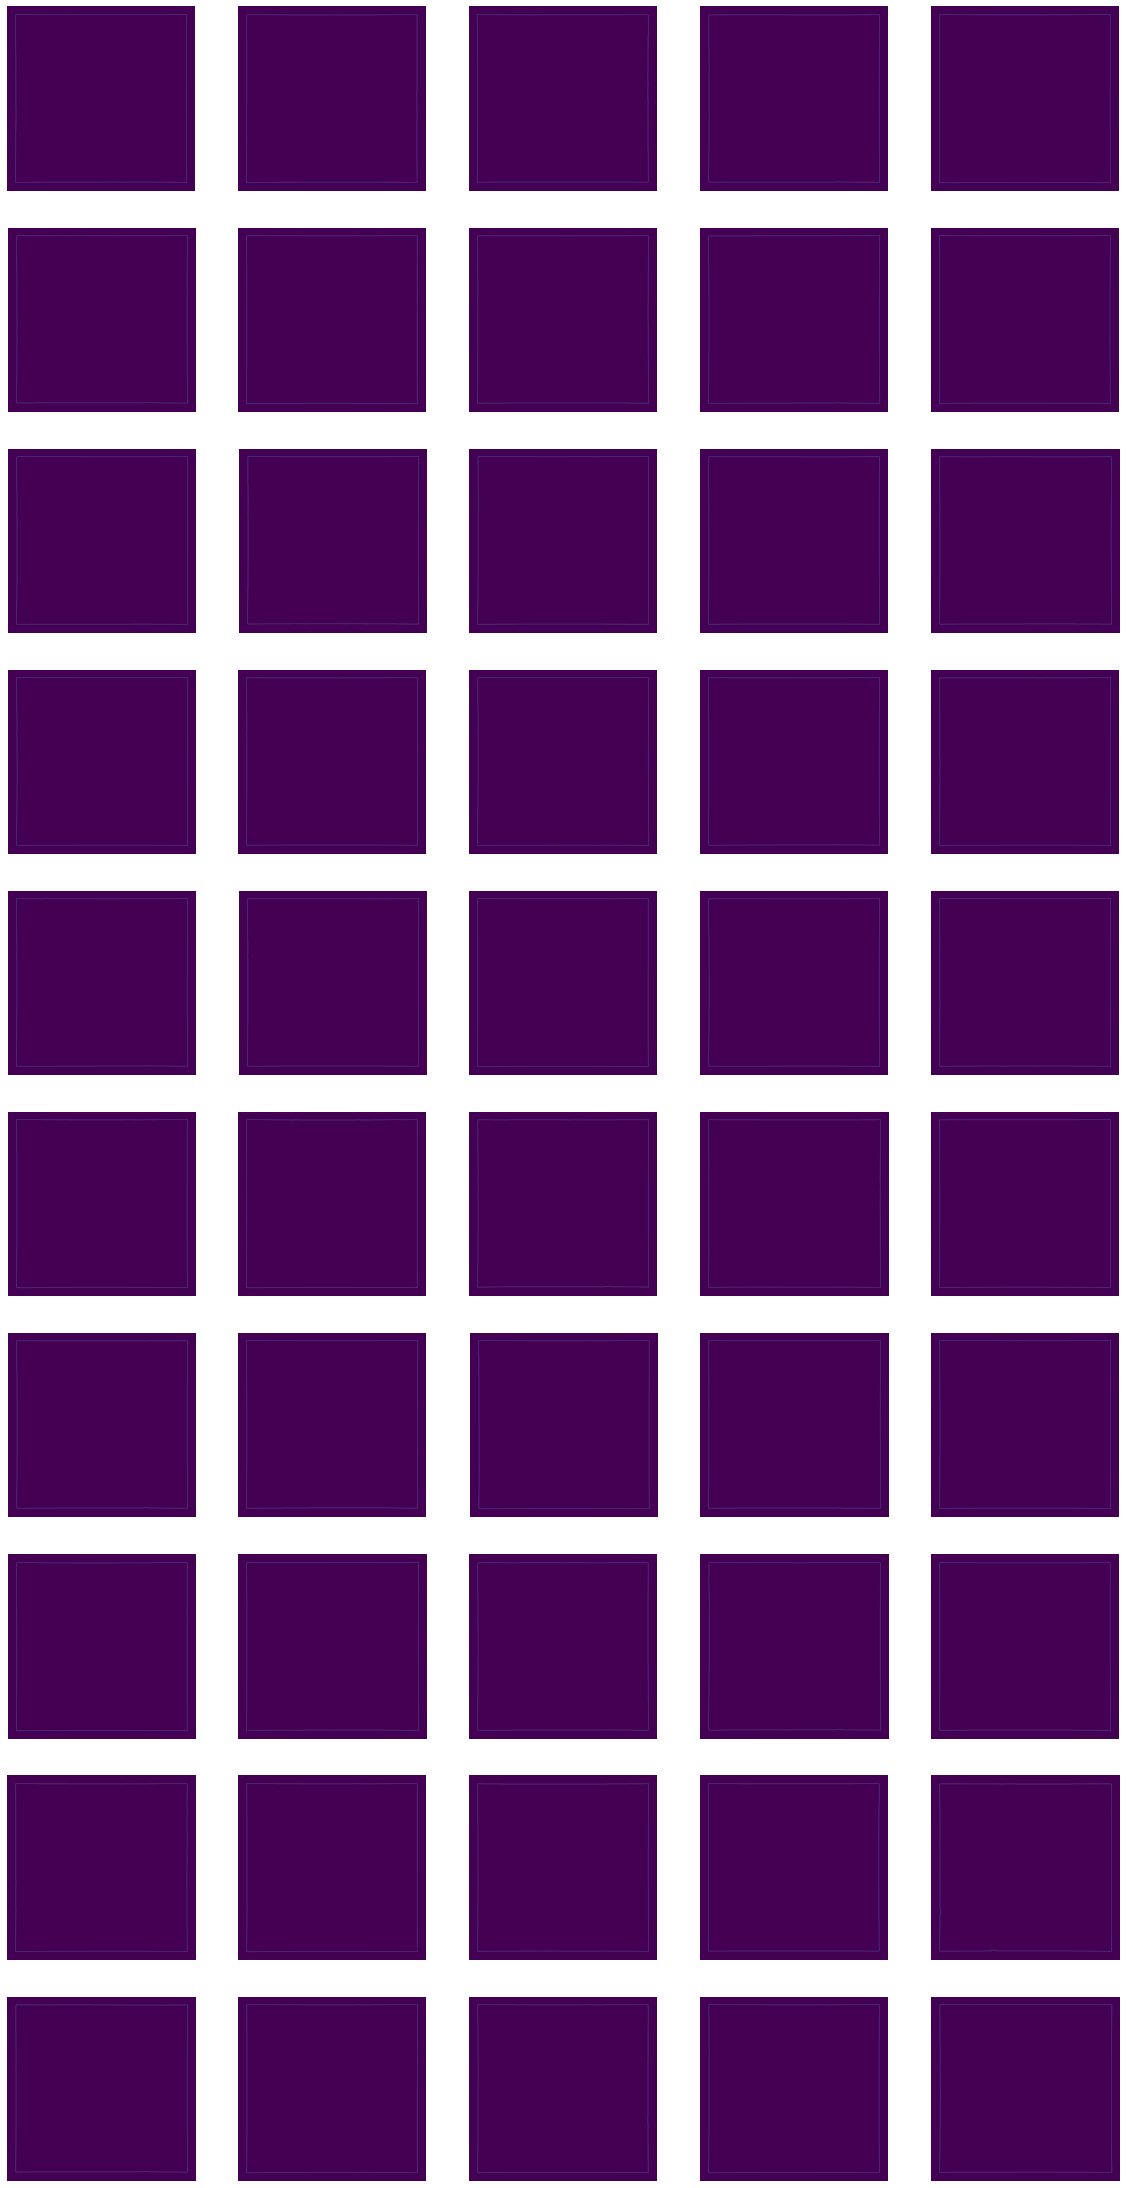

In [ ]:
# Check that our operations work on good amount of pictures
import time

f, axarr = plt.subplots(10, 5, figsize=(20, 40))

for i in range(0,10):
  for j in range(0,5):
    img_name = images_path_list[i*5 + j]

    img = cv2.imread(img_name)

    edges = remove_pattern_noise(img)

    axarr[i,j].imshow(edges)
    axarr[i,j].axis('off')

plt.show()

# Crop picture

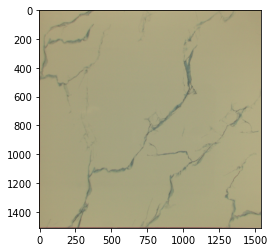

In [ ]:
# Trying to apply transforms based on finding contours
import math

def crop_out(im, vertices):
    width_AD = math.dist(vertices[0][0],vertices[3][0])
    width_BC = math.dist(vertices[1][0],vertices[2][0])
    maxWidth = max(int(width_AD), int(width_BC))

    height_AB = math.dist(vertices[0][0],vertices[1][0])
    height_CD = math.dist(vertices[2][0],vertices[3][0])
    maxHeight = max(int(height_AB), int(height_CD))

    target = np.float32([[0, 0],[0, maxHeight - 1],[maxWidth - 1, maxHeight - 1],[maxWidth - 1, 0]])

    transform = cv2.getPerspectiveTransform(np.float32([vertices[0][0], vertices[1][0], vertices[2][0], vertices[3][0]]), target)  # get the top or bird eye view effect
    return cv2.warpPerspective(im, transform, (maxWidth, maxHeight))

cropped = crop_out(img, vertices)

plt.imshow(cropped)

# Histogram matching

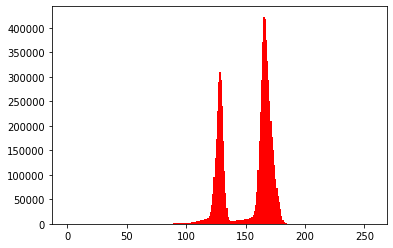

In [ ]:
# Histogram of an image
plt.hist(cropped.flatten(),256,[0,256], color = 'r')
plt.show()

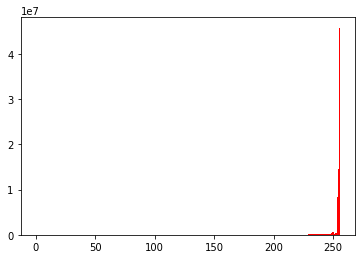

In [ ]:
# Histogram of pattern
pat = cv2.imread("/content/Patterns/AYLIN.tif")
plt.hist(pat.flatten(),256,[0,256], color = 'r')
plt.show()

In [ ]:
from skimage import exposure

def histogram_matching(img, pattern):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_pat = cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)

  matched = exposure.match_histograms(gray_img , gray_pat)

  # img_equ = cv2.equalizeHist(gray_img)
  # pat_equ = cv2.equalizeHist(gray_pat)

  # matched = exposure.match_histograms(img_equ , pat_equ)
  return matched

  # plt.hist(matched.flatten(),256,[0,256], color = 'r')
  # plt.show()

# Making image and pattern similar And Subtraction

### **Original Cropped Image:**

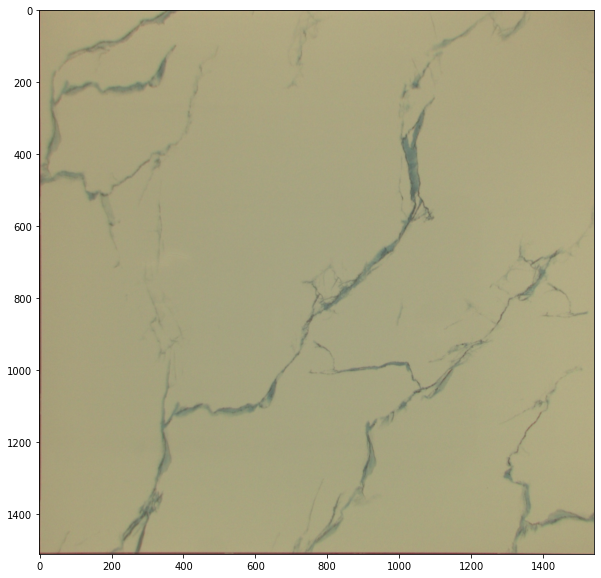

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(cropped, cmap = 'gray')

### **Original Pattern:**

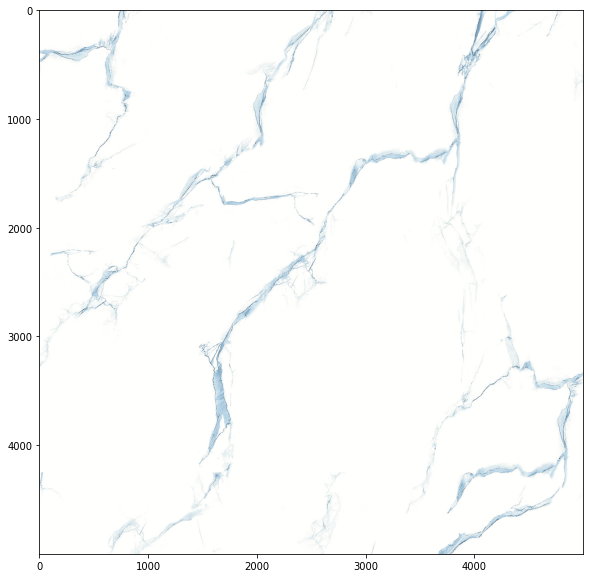

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(pattern, cmap = 'gray')

different shits to test

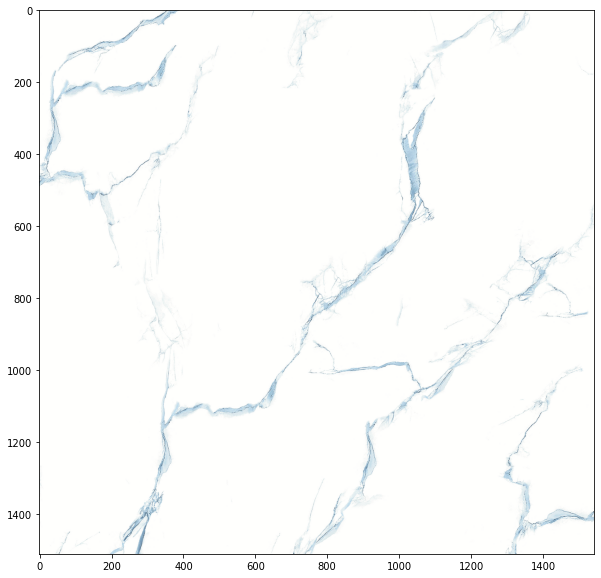

In [ ]:

img1 = pattern.copy()         
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img1 = cv2.GaussianBlur(img1,(7,7),0)

img2 = cropped.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


# Extract location of good matches
points1 = np.zeros((len(good), 2), dtype=np.float32)
points2 = np.zeros((len(good), 2), dtype=np.float32)

for i, match in enumerate(good):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

# Use homography
height, width = img2.shape
scaled_pattern = cv2.warpPerspective(pattern, h, (width, height))

plt.figure(figsize=(10, 10))
plt.imshow(scaled_pattern, "gray")

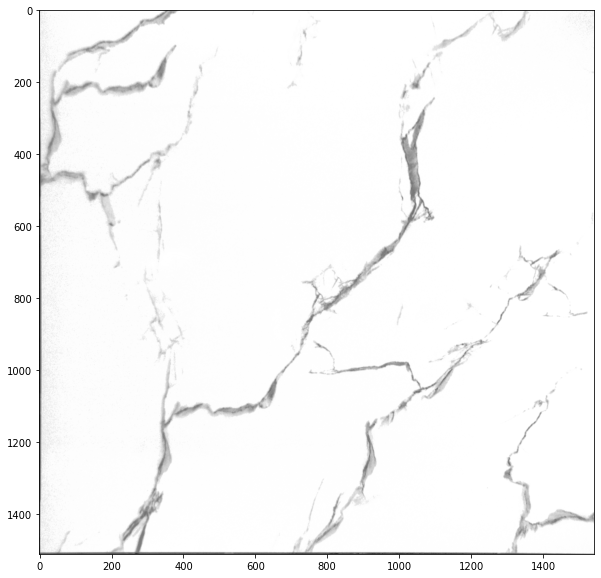

In [ ]:
blured_pattern = cv2.GaussianBlur(scaled_pattern,(11,11),0)
hm_image = histogram_matching(cropped,blured_pattern)

plt.figure(figsize=(10, 10))

plt.imshow(hm_image, cmap = 'gray')

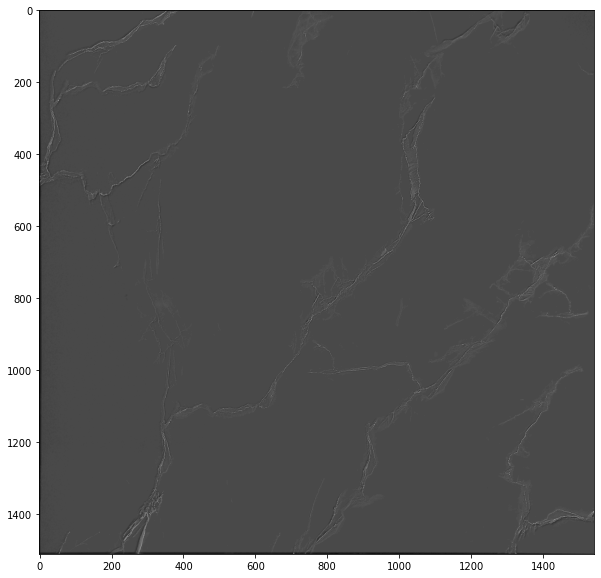

In [ ]:
gray_scaled_pattern = cv2.cvtColor(scaled_pattern, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.imshow(hm_image - gray_scaled_pattern, cmap = 'gray')

In [ ]:
test_shit = cv2.bitwise_and(hm_image, gray_scaled_pattern )

plt.figure(figsize=(10, 10))
plt.imshow(test_shit, cmap = 'gray')

error: ignored

## Parsa idea

* make the photo binary and dilated before subtracting pattern from it

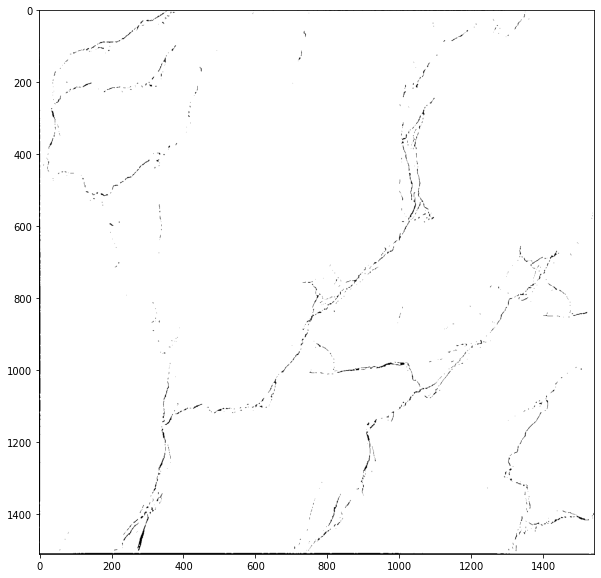

In [ ]:
gray_image = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
blured_image = cv2.GaussianBlur(gray_image,(5,5),0)
adapted_image = cv2.adaptiveThreshold(np.uint8(blured_image), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
# ret3,th3 = cv2.threshold(np.uint8(gray_image),0,255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

dilated_adapted_image = cv2.dilate(adapted_image, np.ones((3,3)))

# ret,image_binary = cv2.threshold(adapted_image,150,255,cv2.THRESH_BINARY)
plt.figure(figsize=(10, 10))
plt.imshow(dilated_adapted_image, cmap = 'gray')

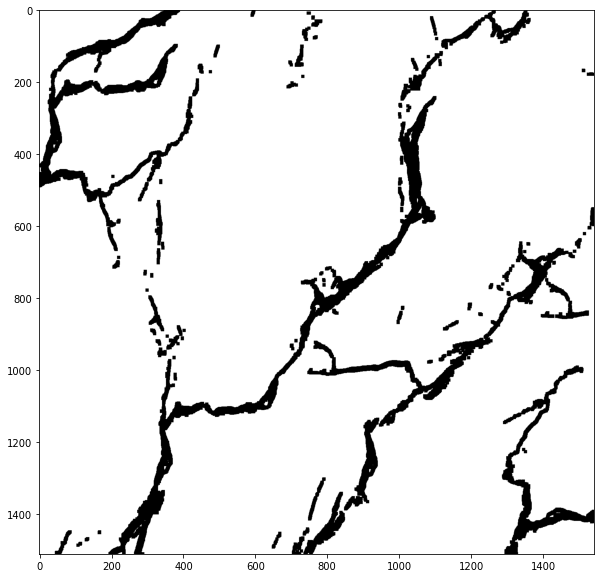

In [ ]:
SIZE = 500

gray_pattern = cv2.cvtColor(scaled_pattern, cv2.COLOR_BGR2GRAY)
blured_pattern = cv2.GaussianBlur(gray_pattern,(5,5),0)
# adapted_pattern = cv2.adaptiveThreshold(np.uint8(gray_pattern), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 2)

ret3,otsu_pattern = cv2.threshold(np.uint8(gray_pattern),0,255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# adapted_image = cv2.resize(adapted_image, (SIZE, SIZE))
# adapted_pattern = cv2.resize(adapted_pattern, (SIZE, SIZE))
dilated_otsu_pattern = cv2.erode(otsu_pattern, np.ones((9,9)))

plt.figure(figsize=(10, 10))
plt.imshow(dilated_otsu_pattern, cmap = 'gray')


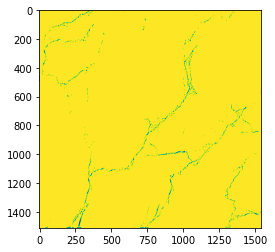

In [ ]:
pat_resized = cv2.resize(dilated_otsu_pattern , (1543, 1512))
not_pattern = pat_resized #cv2.bitwise_not(pat_resized)
plt.imshow(cv2.bitwise_or(not_pattern,dilated_adapted_image) )

## Ideas


# What network to use ??


# Sliding window 

In [130]:
WINDOW_SIZE = 28
IMAGE_SIZE = 1484

# Load mask
mask = cv2.imread("/content/Labels/1644360063.82364.jpg")

# Apply crop
output = remove_pattern_noise(img)

vertices = find_vertices(output)

cropped = crop_out(img, vertices)
mask_cropped = crop_out(mask, vertices)

# Add a resize for both images
img_resized = cv2.resize(cropped , (IMAGE_SIZE, IMAGE_SIZE))
pattern_resized = cv2.resize(pattern, (IMAGE_SIZE, IMAGE_SIZE))
mask_cropped_resized = cv2.resize(mask_cropped, (IMAGE_SIZE, IMAGE_SIZE))

img_resized = cv2.cvtColor(img_resized , cv2.COLOR_BGR2GRAY)
pattern_resized = cv2.cvtColor(pattern_resized , cv2.COLOR_BGR2GRAY)
mask_cropped_resized = cv2.cvtColor(mask_cropped_resized , cv2.COLOR_BGR2GRAY)


# Make windows of images
img_windows = []
pattern_windows = []
mask_windows = []

for y in range(0, IMAGE_SIZE, WINDOW_SIZE):
  for x in range(0, IMAGE_SIZE, WINDOW_SIZE):
    
    # a = img_resized[y:y + WINDOW_SIZE, x:x + WINDOW_SIZE]
    img_windows.append(img_resized[y:y + WINDOW_SIZE, x:x + WINDOW_SIZE])
    pattern_windows.append(pattern_resized[y:y + WINDOW_SIZE, x:x + WINDOW_SIZE])
    mask_windows.append(mask_cropped_resized[y:y + WINDOW_SIZE, x:x + WINDOW_SIZE])

In [114]:
def cvt_mask_label(mask):
  if 255 in mask :
    return 1
  return 0

In [131]:
mask_labels_windows = []
for mask in mask_windows:
  mask_labels_windows.append(cvt_mask_label(mask))

# Make dataset

In [148]:
x_train_1 = np.array( np.float32 (img_windows[:2000]) )
x_train_2 = np.array( np.float32 (pattern_windows[:2000]) ) 
labels_train = np.array( np.float32 (mask_labels_windows[:2000]) )

x_val_1 = np.array( np.float32 (img_windows[2000:]) )
x_val_2 = np.array( np.float32 (pattern_windows[2000:]) )
labels_val = np.array( np.float32 (mask_labels_windows[2000:]) )

# Model

In [110]:
epochs = 10
batch_size = 16
margin = 1  # Margin for constrastive loss.

In [109]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [133]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


In [134]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [135]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_5 (Functional)           (None, 10)           5318        ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 lambda_2 (Lambda)              (None, 1)            0           ['model_5[0][0]',          

In [149]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/10


ValueError: ignored

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

# May be used later
Delete it if they didn't .

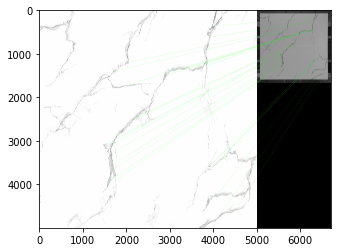

(<matplotlib.image.AxesImage at 0x7f4cea558100>, None)

In [ ]:
MIN_MATCH_COUNT = 10

gray_pat = cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray_pat,None)
kp2, des2 = sift.detectAndCompute(gray_img,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = gray_pat.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(gray_pat,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(gray_pat,kp1,gray_img,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()